# Introduction 

As someone who has always enjoyed exploring new restaurants and dishes I’m constantly on the lookout for the best dining experiences. However relying solely on ratings can be misleading, especially when restaurants with very few reviews have excessively high scores. This inspired me to analyze restaurants in Stockholm and build a more balanced ranking system using Bayesian averages. The goal is to identify the city’s best restaurants by combining ratings with review counts, creating fair and reliable rankings. With this blog post, I hope to discover the best restaurants in Stockholm and share insights that will appeal to food junkies like me.

# Collecting Data Using APIs

To find the best restaurants in Stockholm using a balanced ranking system, I needed reliable data. Instead of using a pre-made dataset I chose to collect the data myself using publicly available APIs, since it allowed me to customize the dataset to fit my needs and ensure it was up-to-date. I started by using the Yelp Fusion API to collect data on restaurants, choosing columns like 'rating', 'reviews', 'review count' and 'address'. The Yelp API can return up to 240 results per search, with a maximum of 50 results per request. To get the next set of results, I used the offset parameter. I chose to request 48 results at a time to stay within the 240-result limit as requesting 50 would have caused an error. I made multiple requests using the term "restaurants" and location set to "Stockholm" and then organized the data into a pandas DataFrame to visualize the results in a table.To ensure my API key remained private, I did not include it directly in my published code. Instead, I saved the retrieved data into a JSON file, which I then loaded into my project for analysis. This method not only protected my API key from being exposed but also made the project more reproducible, as others can work with the saved JSON file without needing access to the API.

In [64]:
# Importing neccesary libraries
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import numpy as np

# API key from Yelp
# YELP_API_KEY = "..." 

# API key and headers
url = "https://api.yelp.com/v3/businesses/search"
headers = {"Authorization": f"Bearer {YELP_API_KEY}"} 

# Fetch restaurants 
restaurants = []
for offset in range(0, 240, 48): 
    params = {
        "term": "restaurants",  
        "location": "Stockholm",  
        "limit": 48,  
        "offset": offset 
    }
    response = requests.get(url, headers=headers, params=params) 
    if response.status_code == 200:
        data = response.json()
        for biz in data["businesses"]:
            restaurants.append({
                "Name": biz["name"],
                "Rating": biz["rating"],
                "Reviews": biz["review_count"],
                "Address": ", ".join(biz["location"]["display_address"])
            })
    else:
        print("Error:", response.status_code)  # Show error code for debugging
        break

# Save Yelp data to a JSON file
with open("yelp_restaurants.json", "w") as file:
    json.dump(restaurants, file)

# Load the Yelp data from the saved JSON file
with open("yelp_restaurants.json", "r") as file:
    yelp_data = json.load(file)

# Convert the data into a DataFrame and display the first few rows
df_yelp = pd.DataFrame(yelp_data)
df_yelp.head()

,Name,Rating,Reviews,Address
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden"
1,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden"
2,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden"
3,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol..."
4,Tegelbacken,4.9,11,"Tegelbacken 2, 111 52 Stockholm, Sweden"


I quickly realised that 240 restaurants wouldn't be enough to accurately represent the restaurants in Stockholm so I decided to use Google Maps Places API to make the dataset more robust. The Google Places API only returns 20 restaurants per request with a maximum of 60 results in total using pagination. To work around this limitation I specified different areas in Stockholm, such as Södermalm, Norrmalm, Östermalm, Gamla Stan and Kungsholmen, where I managed to fetch data for 285 restaurants. However, the function returned a different number of results each time it was run. According to discussions from Stack Overflow, this is likely due to Google's algorithms which functions like a black box, giving different results based on location and other parameters. To make sure pagination works well, I used time.sleep(2) delay between requests to ensure that the API had enough time to return complete results from the API before fetching the next page. By combining data from multiple areas and use pagination, I was able to overcome the API’s limitations and create a more representative dataset for my project.

In [47]:
# API Key from Google and Base URL
# GOOGLE_API_KEY = "..."
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"

# Function to fetch restaurant data with pagination
def fetch_google_restaurants(query):
    restaurants = []
    params = {"query": query, "key": GOOGLE_API_KEY}
    
    while True:
        # Send request to Google API
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Error fetching data for query '{query}': {response.status_code}")
            print(response.json())
            return pd.DataFrame()  # Return an empty DataFrame in case of an error

        # Extract and organize restaurant details
        data = response.json()
        results = data.get("results", [])
        restaurants.extend([{
            "Name": place["name"],
            "Google_Rating": place.get("rating"),
            "Google_Reviews": place.get("user_ratings_total"),
            "Address": place.get("formatted_address")
        } for place in results])

        # Check for next page
        next_page_token = data.get("next_page_token")
        if not next_page_token:
            break
        params["pagetoken"] = next_page_token
        time.sleep(2)  # Wait before fetching the next page
  
    return pd.DataFrame(restaurants)

# Function to fetch restaurant data for multiple areas and combine the results
def fetch_all_google_restaurants(areas):
    all_restaurants = []
    for area in areas:
        query = f"restaurants in {area}, Stockholm"
        all_restaurants.append(fetch_google_restaurants(query))
        time.sleep(1)  
   
    # Combine all areas and remove duplicates based on both Name and Address
    combined_restaurants = pd.concat(all_restaurants, ignore_index=True).drop_duplicates(subset=["Name", "Address"])
    return combined_restaurants

# Areas in Stockholm to find restaurants
areas = ["Södermalm", "Norrmalm", "Östermalm", "Gamla Stan", "Kungsholmen"]
df_google = fetch_all_google_restaurants(areas)

# Display results and save to a file
print(f"Total number of restaurants: {len(df_google)}")
df_google.to_json("google_restaurants.json", orient="records", indent=4)
df_google.head()


Total number of restaurants: 297


,Name,Google_Rating,Google_Reviews,Address
0,Restaurang Kryp In Södermalm,4.9,512,"Timmermansgatan 22, 118 55 Stockholm, Sweden"
1,Blå dörren,4.4,3681,"Södermalmstorg 6, 116 45 Stockholm, Sweden"
2,Restaurant Pelikan,4.4,4324,"Blekingegatan 40, 116 62 Stockholm, Sweden"
3,Restaurant Akkurat - Södermalm,4.4,4144,"Hornsgatan 18, 118 20 Stockholm, Sweden"
4,Restaurant O'PIZZICATO,4.6,1485,"Swedenborgsgatan 23, 118 27 Stockholm, Sweden"


# Combining the Datasets

I now had two DataFrames, one for Yelp data and one for Google data. However the column names for ratings and reviews were different between the two datasets so I renamed the Google columns to match those in the Yelp dataset. I then combined both datasets into a single DataFrame using pd.concat(). Since the datasets contained duplicates, I chose to only keep the entries from Google, which will unlikely to have a notable impact since both datasets are similar in terms of coverage and quality. I then displayed the combined data to get an overview and checked for issues such as NaN values or inconsistencies that could make the dataset unclean. To verify that I had handled the data correctly I used df_combined.isnull().sum() to summarize any missing values, df_combined['Rating'].between(0,5).all() to ensure all the rating values are in the expected range of 0 to 5, and df_combined.duplicated().sum() to check if there are any duplicated rows. As the checks showed that the dataset was clean, I then moved on to create a scoring function.

In [43]:
# Rename columns in Google dataset to match Yelp dataset
df_google.rename(columns={
    "Google_Rating": "Rating",
    "Google_Reviews": "Reviews"
}, inplace=True)

# Combine Yelp and Google datasets and prioritize Google data in case of duplicates
df_combined = pd.concat([df_yelp, df_google], ignore_index=True).drop_duplicates(subset=["Name", "Address"], keep="last")

# Display results and print the number of restaurants
print(f"Total number of restaurants after combining: {len(df_combined)}")
df_combined

Total number of restaurants after combining: 532


,Name,Rating,Reviews,Address
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden"
1,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden"
2,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden"
3,The Fishery Brunkebergstorg,4.8,6,"Brunkebergstorg 14, 111 51 Stockholm, Sweden"
4,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol..."
...,...,...,...,...
527,The Good Gringo,4.3,187,"Scheelegatan 28, 112 28 Stockholm, Sweden"
528,German Beer Hall,4.1,196,"Hantverkargatan 71, 112 38 Stockholm, Sweden"
529,85 Kvadrat Tapas,4.3,155,"John Ericssonsgatan 15, 112 22 Stockholm, Sweden"
530,Lulu,4.5,86,"Pontonjärgatan 28, 112 37 Stockholm, Sweden"


# Developing a Balanced Scoring System 

Since a high rating with only a few reviews doesn’t give much information about the restaurants quality, I needed a scoring function that considers both the rating and the number of reviews when calculating a restaurant’s final rating. For this purpose I decided to use the Bayesian Average, which balances individual restaurant data with the overall global average rating from the dataset. The formula for the Bayesian Average is:
$$ 
\text{Bayesian Average} = \frac{(n \cdot r) + (m \cdot \text{global\_avg})}{n + m}. 
$$
Here $r$ represents the restaurant's average rating, $n$ the number of reviews and global_avg the average rating across all restaurants in the combined dataset. $m$ in this case, is a parameter that controls how much weight is given to the global average compared to each restaurant's data. The parameter is chosen based on the number of reviews in the dataset, where a higher $m$ gives more weight to the global average, which is suitable when restaurants have few reviews. Similarly, a lower $m$ means that each restaurant's rating has a greater impact, which is appropriate when restaurants have a higher number of reviews. To find a suitable value for $m$, I evaluated the number of reviews by using df_combined["Reviews"].describe(). This revealed that the median number of reviews was 169. I chose $m=100$ as a balanced option, since it prevents restaurants with few reviews from ranking too high will also letting restaurants with many reviews to stand out.  

In [48]:
# Function to calculate Bayesian Average
def calculate_bayesian_average(row, global_avg, m):
    n = row["Reviews"]  
    r = row["Rating"] 
    return ((n * r) + (m * global_avg)) / (n + m)

# Calculate global average and define weight
global_avg = df_combined["Rating"].mean()  
m = 100 

# Apply Bayesian Average Scoring
df_combined["Bayesian_score"] = df_combined.apply(calculate_bayesian_average, axis=1, global_avg=global_avg, m=m)
df_combined

,Name,Rating,Reviews,Address,Bayesian_score
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden",4.310973
1,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden",4.329636
2,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden",4.557945
3,The Fishery Brunkebergstorg,4.8,6,"Brunkebergstorg 14, 111 51 Stockholm, Sweden",4.366605
4,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol...",4.574336
...,...,...,...,...,...
527,The Good Gringo,4.3,187,"Scheelegatan 28, 112 28 Stockholm, Sweden",4.314147
528,German Beer Hall,4.1,196,"Hantverkargatan 71, 112 38 Stockholm, Sweden",4.181284
529,85 Kvadrat Tapas,4.3,155,"John Ericssonsgatan 15, 112 22 Stockholm, Sweden",4.315922
530,Lulu,4.5,86,"Pontonjärgatan 28, 112 37 Stockholm, Sweden",4.414302


To rank the restaurants, I sorted the dataset by Bayesian score in descending order so that the highest-scoring restaurants appeared at the top. I then selected the top 20 and reset the index to start from 1 to make the table easier to read. The table includes important details like the restaurant name, Bayesian score, rating, number of reviews, and address. To make the results clearer, I also created a bar chart to show the Bayesian scores of the top restaurants.

,Name,Bayesian_score,Rating,Reviews,Address
1,Aleks y Filip,4.831864,4.9,721,"Bjälbogatan 32, 118 66 Stockholm, Sweden"
2,Restaurang Kryp In Södermalm,4.808595,4.9,512,"Timmermansgatan 22, 118 55 Stockholm, Sweden"
3,Tajrish restaurang,4.762893,4.9,308,"Torsgatan 31, 113 21 Stockholm, Sweden"
4,FIKA & WINE,4.749627,4.8,812,"Österlånggatan 5, 111 31 Stockholm, Sweden"
5,The kulture,4.742718,4.8,702,"Fridhemsgatan 3, 112 40 Stockholm, Sweden"
6,Frantzén,4.738086,4.8,642,"Klara Norra kyrkogata 26, 111 22 Stockholm, Sw..."
7,Adam/Albin,4.735387,4.8,611,"Rådmansgatan 16, 114 25 Stockholm, Sweden"
8,Cong,4.735296,4.8,610,"Kornhamnstorg 51, 111 27 Stockholm, Sweden"
9,Aama Himalayan Kitchen Stockholm,4.733421,4.8,590,"Fridhemsgatan 15, 112 40 Stockholm, Sweden"
10,Mormors Lilla Kök,4.728443,4.8,542,"Rosenlundsgatan 23, 118 63 Stockholm, Sweden"


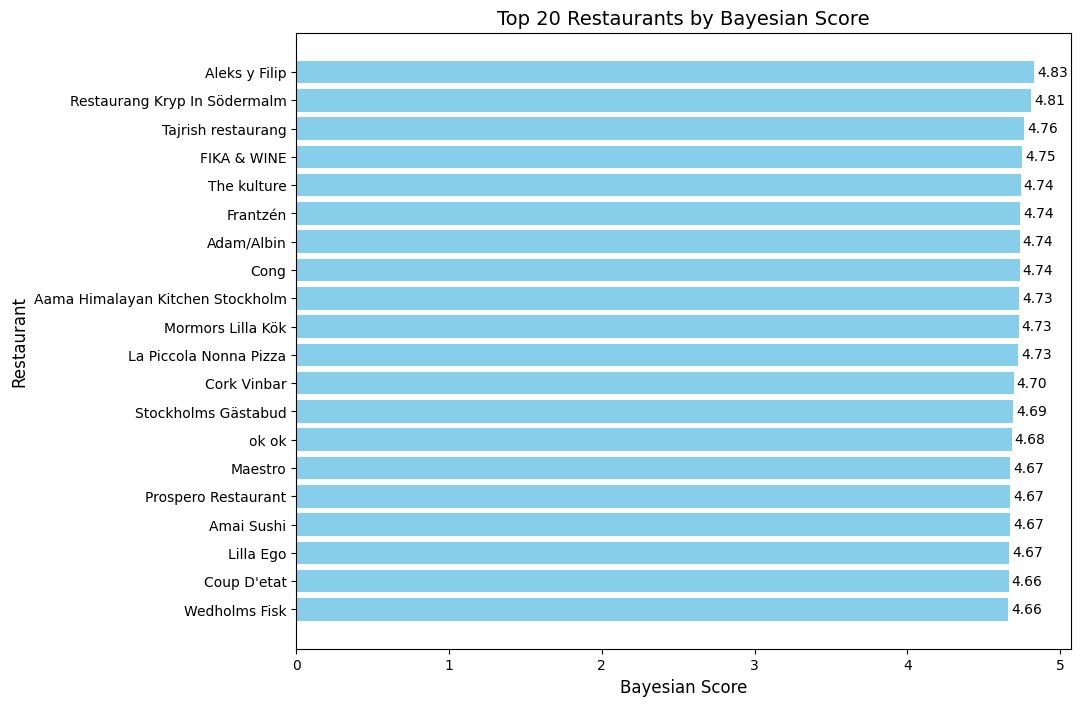

In [75]:
# Sort by Bayesian score and select the top 20 restaurants
top_restaurants = df_combined.sort_values(by="Bayesian_score", ascending=False).head(20)

# Reset the index to start from 1
top_restaurants = top_restaurants.reset_index(drop=True)
top_restaurants.index += 1  

# Bayesian score and rating are placed side by side for easier comparison
columns = ["Name", "Bayesian_score", "Rating", "Reviews", "Address"]
display(top_restaurants[columns])

# Create a bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(top_restaurants["Name"], top_restaurants["Bayesian_score"], color="skyblue")
plt.xlabel("Bayesian Score", fontsize=12)
plt.ylabel("Restaurant", fontsize=12)
plt.title("Top 20 Restaurants by Bayesian Score", fontsize=14)
plt.gca().invert_yaxis()  # Reverse order for better readability

# Add annotations
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va='center', fontsize=10)

plt.show()

The bar chart shows that "Aleks y Filip" ranks first with a Bayesian score of 4.83, followed closely by "Restaurang Kryp In Södermalm" at 4.81 and "Tajrish restaurang" at 4.76. The scores are very close, suggesting strong competition among the top restaurants, with many providing equally great experiences. The rankings include a mix of cuisines and dining styles, showing that no single type of restaurant dominates the list. This variety highlights the many dining options in Stockholm, offering something for everyone. It also reflects the city's diverse food culture and the wide-ranging food preferences of Stockholm's residents.

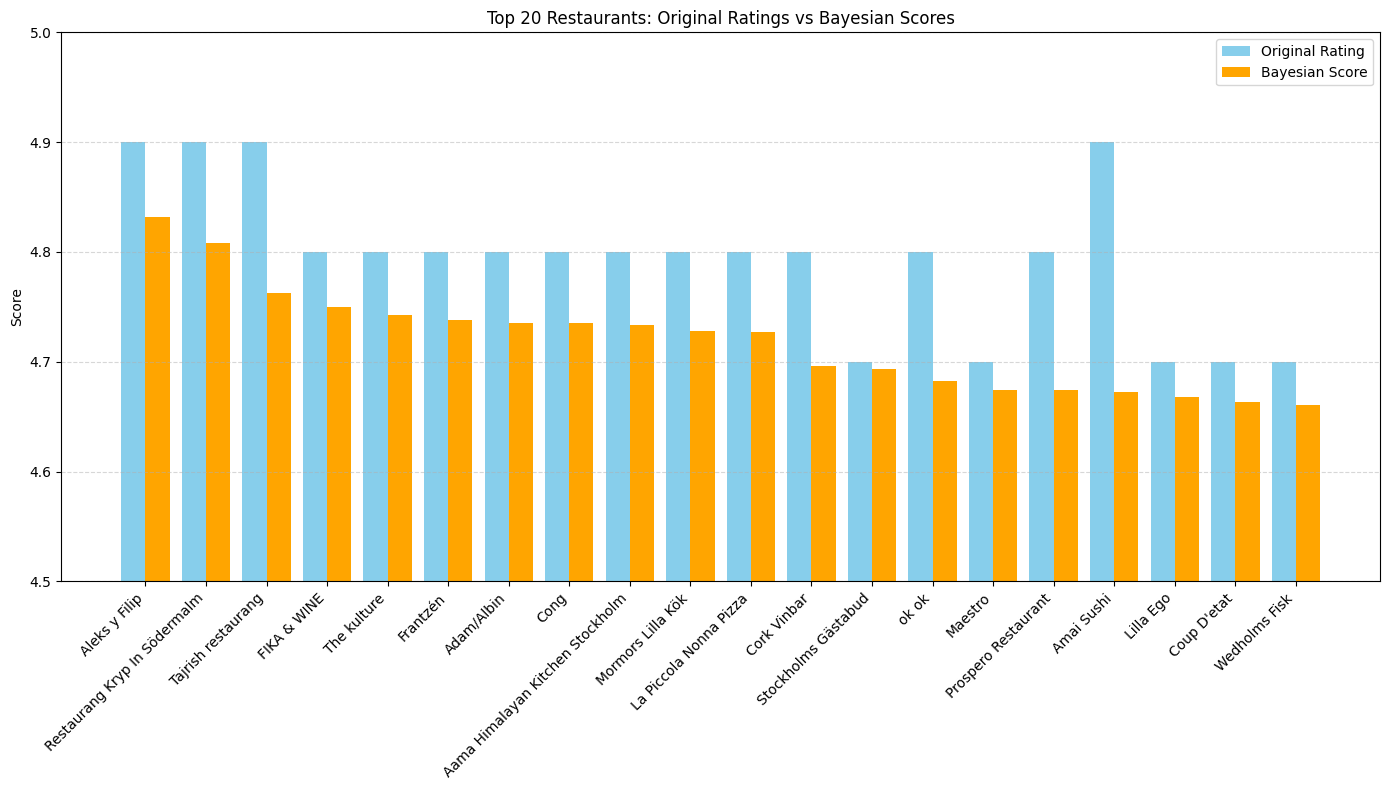

In [73]:
# Select the top 20 restaurants based on Bayesian score
comparison_top20 = df_combined[["Name", "Rating", "Bayesian_score"]].sort_values(by="Bayesian_score", ascending=False).head(20)

# Set positions and bar width
x_positions = np.arange(len(comparison_top20))
bar_width = 0.4

# Use consistent colors
original_color = "skyblue"
bayesian_color = "orange"

# Create bar chart
plt.figure(figsize=(14, 8))
plt.bar(x_positions - bar_width/2, comparison_top20["Rating"], bar_width, label="Original Rating", color=original_color)
plt.bar(x_positions + bar_width/2, comparison_top20["Bayesian_score"], bar_width, label="Bayesian Score", color=bayesian_color)

# Add labels and title
plt.xticks(x_positions, comparison_top20["Name"], rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(4.5, 5)  # Adjust Y-axis limits for a better plot
plt.title("Top 20 Restaurants: Original Ratings vs Bayesian Scores")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Add gridlines for better readability
plt.tight_layout()
plt.show()

The bar chart shows the differences between original ratings and Bayesian scores for the top 20 restaurants. Restaurants like "Aleks y Filip" and "Restaurang Kryp In Södermalm" maintain high rankings in both scoring systems because they have strong ratings supported by a large number of reviews, which shows that their scores are reliable and well-deserved. However some restaurants like "La Piccola Nonna Pizza" and "Cork Vinbar," drop in the rankings after adjusting the scoring system. This happens because they have fewer reviews and the Bayesian scoring function balances their ratings by factoring in the global average. This prevents restaurants with fewer reviews from ranking too high. For mid-ranked restaurants like "Adam/Albin" and "FIKA & WINE," the adjustment has little effect, suggesting these places have both solid ratings and enough reviews to support their scores. In contrast, restaurants like "Wedholms Fisk" see a bigger drop, which highlights how important the number of reviews is for fair rankings.